## Previous work

![Previous work](./previous_work_reduce.png "Previous work")

## Introduction 

My goal was to generate python functions, using only math, numpy and pure python, with a algorithm approche, simplicity and easy to port to C.
For each attention mask (a, b, c and d ), i have written the following features : 
- generate a mask, using the corresponding parameter
- same, but based on a given sparsity (by having a function : given sparsity -> parameter)
- generate artificial matrix of only ones and zero based on the mask
- a test function which shows how to use it and the output

## Code

#### Imports

In [276]:
import numpy as np
import matplotlib.pyplot as plt
import math

## UTILS

In [277]:
def get_nb_non_zero(matrix):
    return np.count_nonzero(matrix)

In [278]:
def get_density(matrix, length):
    return float(get_nb_non_zero(matrix)) / float(length * length)

In [279]:
def get_sparsity(matrix, length):
    return 1.0 - get_density(matrix, length)

In [280]:
def show_matrix_infos(matrix, length):
    # conditions : shape(matrix) = (length, length)
    sparsity = get_sparsity(matrix, length)
    text = f"Given length : ({length}, {length}) and calculated length : {np.shape(matrix)} sparsity = {sparsity}"
    plt.title(label=text)
    plt.imshow(matrix, cmap='gray', interpolation='nearest')
    plt.colorbar()
    plt.show()

## RANDOM ATTENTION

### By number of non-zeros per row

In [281]:
def get_random_attention_mask(length, nz_per_row):
    # conditions : nz_per_row <= length
    rng = np.random.default_rng()
    mask = rng.multivariate_hypergeometric([1]*length, nz_per_row, size=length).astype(bool)
    return mask

In [282]:
def generate_matrix_with_random_attention_mask(length, nz_per_row):
    # conditions : nz_per_row <= length
    matrix = np.zeros((length, length))
    mask = get_random_attention_mask( length=length, nz_per_row=nz_per_row)
    matrix[mask] = 1
    return matrix

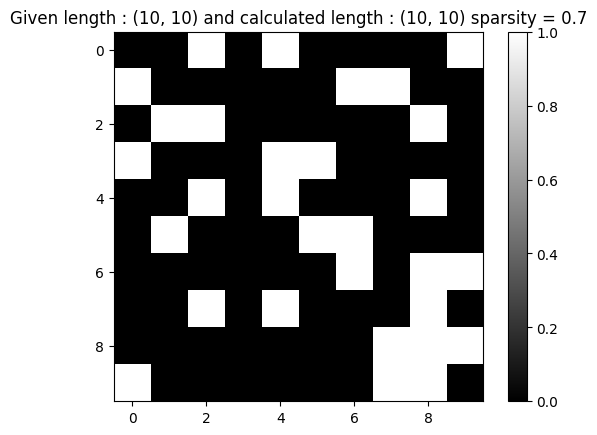

In [283]:
def test_generate_matrix_with_random_attention_mask():
    length = 10
    nz_per_row = 3
    matrix = generate_matrix_with_random_attention_mask(length=length, nz_per_row=nz_per_row)
    show_matrix_infos(matrix=matrix, length=length)

test_generate_matrix_with_random_attention_mask()

### By sparsity

In [284]:
def best_nz_per_row_from_sparsity(length, sparsity):
    # conditions : 0 <= sparsity <= 1
    return round(length * (1 - sparsity))

In [285]:
def get_random_attention_mask_with_sparsity(length, sparsity):
    # conditions : 0 <= sparsity <= 1
    nz_per_row=best_nz_per_row_from_sparsity(length=length, sparsity=sparsity)
    return get_random_attention_mask( length=length, nz_per_row=nz_per_row)

In [286]:
def generate_matrix_with_random_attention_mask_with_sparsity(length, sparsity):
    # conditions : 0 <= sparsity <= 1
    matrix = np.zeros((length, length))
    mask = get_random_attention_mask_with_sparsity(length=length, sparsity= sparsity)
    matrix[mask] = 1
    return matrix

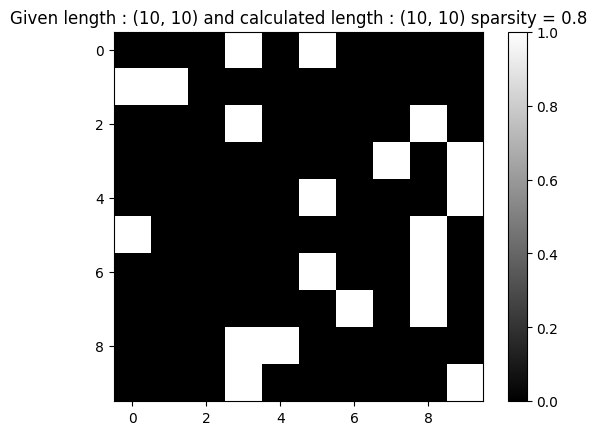

In [287]:
def test_generate_matrix_with_random_attention_mask_with_sparsity():
    length = 10
    sparsity = 0.8
    matrix = generate_matrix_with_random_attention_mask_with_sparsity(length=length, sparsity=sparsity)
    show_matrix_infos(matrix=matrix, length=length)

test_generate_matrix_with_random_attention_mask_with_sparsity()

## WINDOW ATTENTION

![Tridiagonal matrix Image](tridiagonal_matrix.png "Tridiagonal matrix")

### Utils

In [288]:
def diagonal_area(length,diagonal_width):
    # conditions : length
    if(diagonal_width == 0):
        return 0
    else:
        n = length
        #semi diagonal widht
        sdw = diagonal_width // 2 # (diagonal_width / 2 - 1 because is odd)
        da = n * ( 1 + 2 * sdw ) - sdw * (sdw + 1)
        return da

### By diagonal width

In [289]:
def get_window_attention_mask (length, diagonal_width):
    # conditions : shape(matrix) = (length, length), 0 <= diagonal_width <= 2*length - 1 (cover full matrix), diagonal_width is odd
    mask = np.zeros(shape=(length, length), dtype=bool)
    if (diagonal_width > 0):
        sdw = diagonal_width // 2
        if diagonal_width == 1:
            mask = np.fromfunction(lambda i, j:  j == i,shape=(length, length), dtype=int)
        else : 
            mask = np.fromfunction(lambda i, j:  np.abs(i - j) <= sdw ,shape=(length, length), dtype=int)
    return mask
    

In [290]:
def generate_matrix_with_window_attention_mask(length, diagonal_width):
    # conditions :  0 <= diagonal_width <= 2*length - 1 (cover full matrix), diagonal_width is odd
    matrix = np.zeros((length, length))
    mask = get_window_attention_mask( length= length, diagonal_width=diagonal_width)
    matrix[mask] = 1
    return matrix

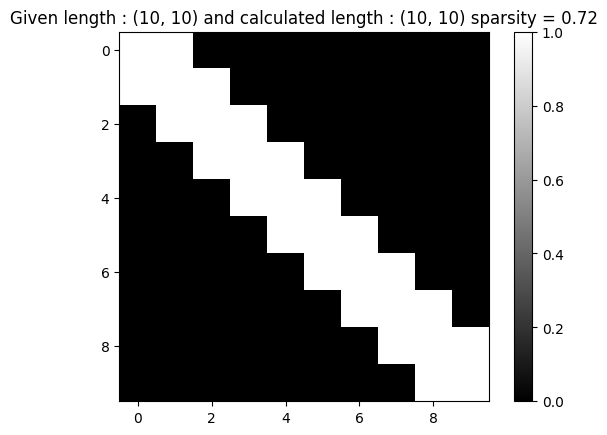

In [291]:
def test_generate_matrix_with_window_attention_mask():
    length = 10
    diagonal_width = 3
    matrix = generate_matrix_with_window_attention_mask(length=length, diagonal_width=diagonal_width)
    show_matrix_infos(matrix,length)

test_generate_matrix_with_window_attention_mask()

### By sparsity

In [292]:
def best_diagonal_width_from_sparsity(length, sparsity):
    n = length
    density = 1.0 - sparsity
     # ideal diagonal aera
    da = n * n * density
    # from this point, all is explained in the related document
    a = -1
    b = 2 * n - 1
    c = n - da
    det = b * b - 4 * a * c
    x = (-b + math.sqrt(det))/(2 * a)
    
    sdw = round(x)
    
    dw = 2 * sdw + 1
    
    if(dw < 0) : dw = 0
    elif(dw > 2*n - 1): dw = 2*n - 1
    # print(f"For matrix of size: {n} and given sparsity: {sparsity}, ideal semi diagonal width is : {x}, chosen dw is {dw}")
    return dw    

In [293]:
def test_diagonal_width_from_sparsity():
    sparsity_values = [0.1, 0.25, 0.5, 0.75, 0.9]
    lengths = [10, 100, 250, 500, 1000]
    colors = ['red', 'blue', 'green', 'yellow', 'purple']
    
    plt.figure(figsize=(8, 6))

    plt.plot([0, 1], [0, 1], 'k--', alpha=0.7, label='y=x')

    for length, color in zip(lengths, colors):
        given_sparsity = []
        real_sparsity = []
        
        for sparsity in sparsity_values:
            da = best_diagonal_width_from_sparsity(length, sparsity)
            real_sp = 1.0 - (float(diagonal_area(length, da)) / float(length * length))
            given_sparsity.append(sparsity)
            real_sparsity.append(real_sp)
        
        plt.plot(given_sparsity, real_sparsity, 'o-', color=color, label=f'n={length}')
    plt.xlabel('Given Sparsity')
    plt.ylabel('Real Sparsity')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

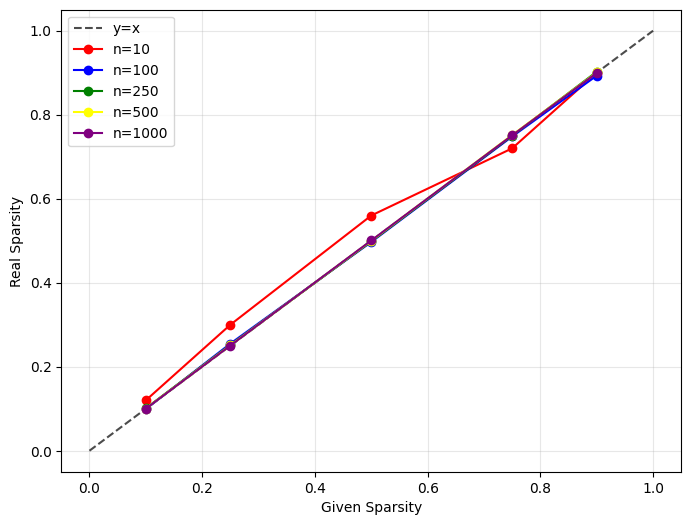

In [294]:
# test function hided for render
test_diagonal_width_from_sparsity()

In [295]:
def get_window_attention_mask_with_sparsity( length, sparsity):
    # conditions : 0 <= sparsity <= 1
    dw = best_diagonal_width_from_sparsity(length, sparsity)
    return get_window_attention_mask( length=length, diagonal_width=dw)

In [296]:
def generate_matrix_with_window_attention_mask_with_sparsity(length, sparsity):
    # conditions :  0 <= diagonal_width <= 2*length - 1 (cover full matrix), diagonal_width is odd
    matrix = np.zeros((length, length))
    matrix = get_window_attention_mask_with_sparsity( length= length, sparsity=sparsity)
    return matrix

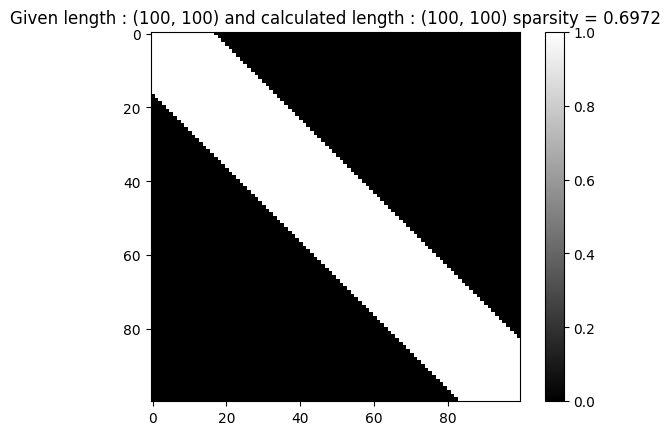

In [297]:
def test_generate_matrix_with_window_attention_mask_with_sparsity():
    length = 100
    sparsity = 0.7
    matrix = generate_matrix_with_window_attention_mask_with_sparsity(length=length, sparsity=sparsity)
    show_matrix_infos(matrix,length)

test_generate_matrix_with_window_attention_mask_with_sparsity()

# GLOBAL ATTENTION

### Utils

In [298]:
def global_attention_aera(length,global_attention_width):
    w = global_attention_width
    n = length
    return (2 * w * n) - (w * w)

print(global_attention_aera(10,2))

36


In [299]:
def get_global_attention_mask( length, global_width):
    mask = np.zeros(shape=(length,length), dtype=bool)
    mask[:global_width,:] = True
    mask[global_width : , : global_width] = True
    return mask

In [300]:
def generate_matrix_with_global_attention_mask(length, global_width):
    matrix = np.zeros((length, length))
    mask = get_global_attention_mask( length=length, global_width=global_width)
    matrix[mask] = 1
    return matrix

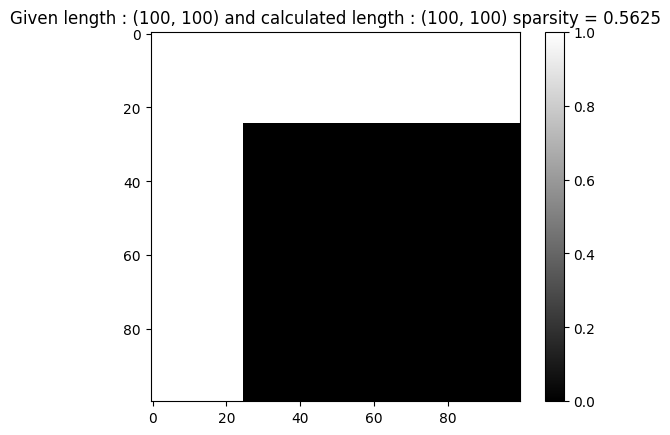

In [301]:
def test_generate_matrix_with_global_attention_mask():
    length = 100
    global_width = 25
    matrix = generate_matrix_with_global_attention_mask(length=length, global_width=global_width)
    show_matrix_infos(matrix=matrix, length=length)
    
test_generate_matrix_with_global_attention_mask()

In [302]:
def best_global_width_from_sparsity(length, sparsity):
    n = length
    density = 1.0 - sparsity
     # ideal diagonal aera
    ga = n * n * density
    # same as window mask but easier
    a = -1
    b = 2 * n
    c = - ga
    det = b * b - 4 * a * c
    x = (-b + math.sqrt(det))/(2 * a)
    gw = round(x)
    if(gw < 0) : gw = 0
    elif(gw > n * n ): gw = n * n
    return gw 

In [303]:
def test_global_width_from_sparsity():
    sparsity_values = [0.1, 0.25, 0.5, 0.75, 0.9]
    lengths = [10, 100, 250, 500, 1000]
    colors = ['red', 'blue', 'green', 'yellow', 'purple']
    
    plt.figure(figsize=(8, 6))

    plt.plot([0, 1], [0, 1], 'k--', alpha=0.7, label='y=x')

    for length, color in zip(lengths, colors):
        given_sparsity = []
        real_sparsity = []
        
        for sparsity in sparsity_values:
            ga = best_global_width_from_sparsity(length, sparsity)
            real_sp = 1.0 - (float(global_attention_aera(length, ga)) / float(length * length))
            given_sparsity.append(sparsity)
            real_sparsity.append(real_sp)
        
        plt.plot(given_sparsity, real_sparsity, 'o-', color=color, label=f'n={length}')
    plt.xlabel('Given Sparsity')
    plt.ylabel('Real Sparsity')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

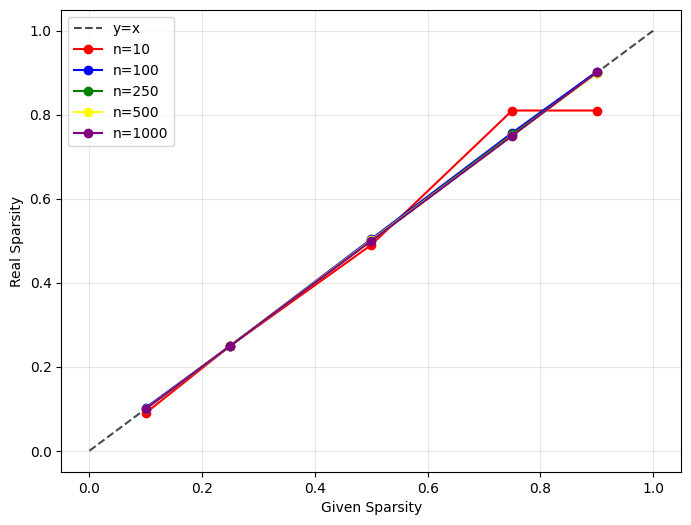

In [304]:
# test function hided for render
test_global_width_from_sparsity()

In [305]:
def get_global_attention_mask_with_sparsity( length, sparsity):
    # conditions : 0 <= sparsity <= 1
    gw = best_global_width_from_sparsity(length, sparsity)
    return get_global_attention_mask( length=length, global_width=gw)

In [306]:
def generate_matrix_with_global_attention_mask_with_sparsity(length, sparsity):
    matrix = np.zeros((length, length))
    mask = get_global_attention_mask_with_sparsity(length=length, sparsity=sparsity)
    matrix[mask] = 1
    return matrix

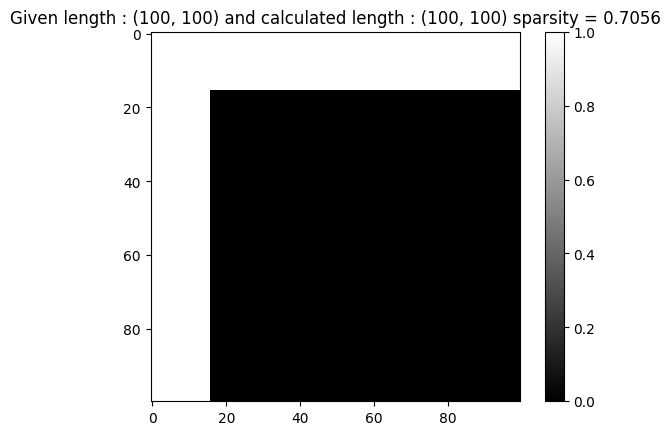

In [307]:
def test_generate_matrix_with_global_attention_mask_with_sparsity():
    length = 100
    sparsity = 0.7
    matrix = generate_matrix_with_global_attention_mask_with_sparsity(length=length, sparsity=sparsity)
    show_matrix_infos(matrix=matrix, length=length)
    
test_generate_matrix_with_global_attention_mask_with_sparsity()

## BIG BIRD (combination of all above)

In [308]:
def get_big_bird_mask(length, nz_per_row, diagonal_width, global_width):
    am = get_random_attention_mask( length= length, nz_per_row=nz_per_row)
    wm = get_window_attention_mask( length= length, diagonal_width=diagonal_width)
    gm = get_global_attention_mask( length=length, global_width= global_width)
    total_mask = am | wm | gm 
    return total_mask

In [309]:
def generate_big_bird(length, nz_per_row, diagonal_width, global_width ):
    matrix = np.zeros((length, length))
    mask = get_big_bird_mask( length=length, nz_per_row= nz_per_row, diagonal_width=diagonal_width, global_width= global_width)
    matrix[mask] = 1
    return matrix

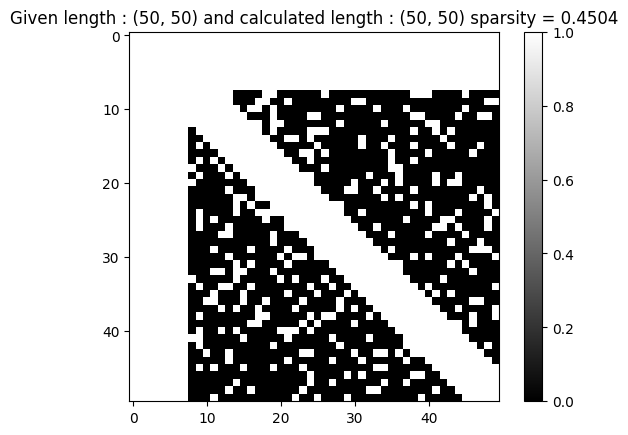

In [310]:
def test_generate_big_bird():
    length = 50
    nz_per_row = 10
    diagonal_width = 8
    global_width = 8
    matrix = generate_big_bird(length=length,nz_per_row=nz_per_row, diagonal_width=diagonal_width, global_width=global_width)
    show_matrix_infos(matrix=matrix, length= length)
    
test_generate_big_bird()
    

In [311]:
def get_big_bird_mask_with_sparsity( length, random_sparsity, window_sparsity, global_sparsity):
    am = get_random_attention_mask_with_sparsity( length= length, sparsity=random_sparsity)
    wm = get_window_attention_mask_with_sparsity( length= length,sparsity=window_sparsity )
    gm = get_global_attention_mask_with_sparsity(length=length, sparsity=global_sparsity)
    total_mask = am | wm | gm 
    return total_mask

In [312]:
def generate_big_bird_with_sparsity(length, random_sparsity, window_sparsity, global_sparsity):
    matrix = np.zeros((length, length))
    mask = get_big_bird_mask_with_sparsity(length, random_sparsity, window_sparsity, global_sparsity)
    matrix[mask] = 1
    return matrix

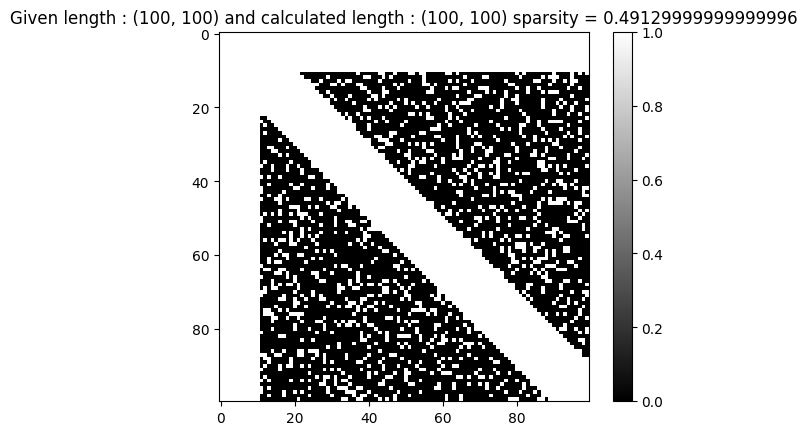

In [313]:
def test_generate_big_bird_with_sparsity():
    length = 100
    random_sparsity =  0.8
    window_sparsity = 0.8
    global_sparsity = 0.8
    matrix = generate_big_bird_with_sparsity(length=length,random_sparsity=random_sparsity, window_sparsity=window_sparsity, global_sparsity=global_sparsity)
    show_matrix_infos(matrix=matrix, length= length)
    
test_generate_big_bird_with_sparsity()

In [314]:
def adjust_total_sparsity(total_sparsity):
    x = total_sparsity
    # degree = 3
    # a = 2.61815675
    # b = -4.77052715
    # c = 2.98999146
    # d = 0.19945692
    # res =  a  * ( x ** 3 )  + b * (x ** 2) + c * x
    # degree = 5
    a = 24.08862473
    b = -65.2963488
    c = 64.48601296
    d = -28.42365239 
    e = 5.98076684
    f = 0.17082526
    poly =  a * x**5 + b * x**4 + c * x**3 + d * x**2 + e * x + f
    res = min(max(poly, 0.0), 1.0)
    return res

In [316]:
def get_big_bird_mask_with_total_sparsity( length, total_sparsity, adjust):
    if adjust :
        total_sparsity = adjust_total_sparsity(total_sparsity)
    random_sparsity = total_sparsity
    window_sparsity = total_sparsity
    global_sparsity = total_sparsity
    total_mask = get_big_bird_mask_with_sparsity( length, random_sparsity, window_sparsity, global_sparsity)
    return total_mask

In [317]:
def generate_big_bird_with_total_sparsity(length,total_sparsity, adjust):
    matrix = np.zeros((length, length))
    mask = get_big_bird_mask_with_total_sparsity(length, total_sparsity, adjust)
    matrix[mask] = 1
    return matrix

In [318]:
def find_approximation():
    sparsity_values = [x / 100.0 for x in range(0, 101, 5)]
    length = 2000
    
    given_sparsity = []
    real_sparsity = []
    
    for sparsity in sparsity_values:
        matrix = generate_big_bird_with_total_sparsity(length, sparsity, adjust=False)
        real_sp = get_sparsity(matrix, length)
        given_sparsity.append(sparsity)
        real_sparsity.append(real_sp)
    
    sort_idx = np.argsort(real_sparsity)
    real_sorted = np.array(real_sparsity)[sort_idx]
    given_sorted = np.array(given_sparsity)[sort_idx]
    
    coeffs = np.polyfit(real_sorted, given_sorted, 5)
    
    print(f"a = {coeffs[0]}")
    print(f"b = {coeffs[1]}")
    print(f"c = {coeffs[2]}")
    print(f"d = {coeffs[3]}")
    print(f"e = {coeffs[4]}")
    print(f"f = {coeffs[5]}")
    print(f"poly = a * x**5 + b * x**4 + c * x**3 + d * x**2 + e * x + f")

find_approximation()

a = 24.05343481691277
b = -65.20422071298265
c = 64.40037116439068
d = -28.390296925558
e = 5.975994481056873
f = 0.17093927522017097
poly = a * x**5 + b * x**4 + c * x**3 + d * x**2 + e * x + f


Given sparsity = 0.8


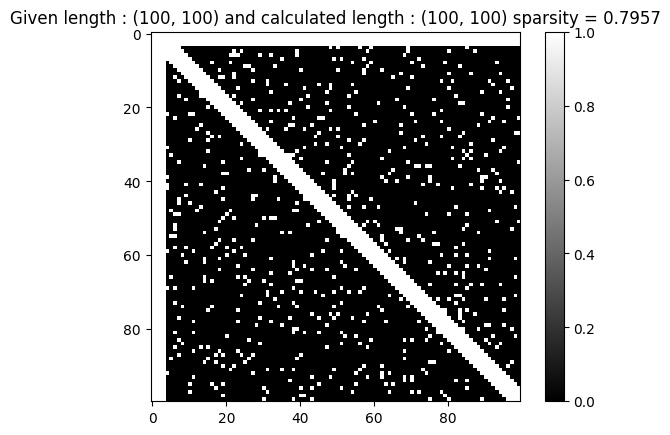

In [319]:
def test_generate_big_bird_with_total_sparsity():
    length = 100
    total_sparsity = 0.8
    adjust = True
    matrix = generate_big_bird_with_total_sparsity(length, total_sparsity, adjust)
    print(f"Given sparsity = {total_sparsity}")
    show_matrix_infos(matrix, length)
    
test_generate_big_bird_with_total_sparsity()

Without adjusting :


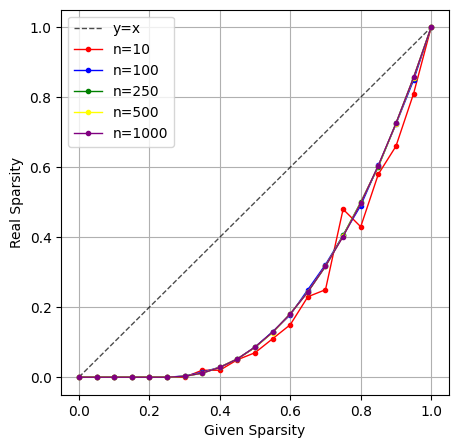

When adjusting the given sparsity : 


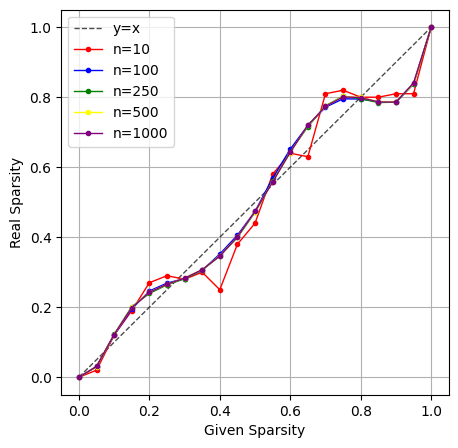

In [320]:
def benchmark_generate_big_bird_with_total_sparsity(adjust):
    sparsity_values = [x / 100.0 for x in range(0, 101, 5)]
    lengths = [10, 100, 250, 500, 1000 ]
    colors = ['red', 'blue', 'green', 'yellow', 'purple']
    
    plt.figure(figsize=(5, 5))
    plt.plot([0, 1], [0, 1], 'k--', alpha=0.7, linewidth=1, label='y=x')
    for length, color in zip(lengths, colors):
        given_sparsity = []
        real_sparsity = []
        
        for sparsity in sparsity_values:
            matrix = generate_big_bird_with_total_sparsity(length, sparsity, adjust= adjust)
            real_sp = get_sparsity(matrix, length)
            given_sparsity.append(sparsity)
            real_sparsity.append(real_sp)
        
        plt.plot(given_sparsity, real_sparsity, 'o-', color=color, linewidth=1, markersize=3, label=f'n={length}')  

    plt.xlabel('Given Sparsity')
    plt.ylabel('Real Sparsity')
    plt.legend()
    plt.grid(True)
    plt.show()

print("Without adjusting :")
benchmark_generate_big_bird_with_total_sparsity(False)
print("When adjusting the given sparsity : ")
benchmark_generate_big_bird_with_total_sparsity(True)